In [ ]:
import pandas as pd

try:
    data = pd.read_csv('/content/AI EarthHack Dataset.csv', encoding='utf-8')
except UnicodeDecodeError:
    try:
        data = pd.read_csv('/content/AI EarthHack Dataset.csv', encoding='ISO-8859-1')
    except UnicodeDecodeError:
        try:
            data = pd.read_csv('/content/AI EarthHack Dataset.csv', encoding='cp1252')
        except UnicodeDecodeError:
            print("Failed to decode using popular encodings. Please check the file encoding.")

In [ ]:
data.head()

,id,problem,solution
0,1,The construction industry is indubitably one o...,"Herein, we propose an innovative approach to m..."
1,2,"I'm sure you, like me, are feeling the heat - ...","Imagine standing on a green hill, not a single..."
2,3,The massive shift in student learning towards ...,"Implement a """"Book Swap"""" program within educa..."
3,4,The fashion industry is one of the top contrib...,The proposed solution is a garment rental serv...
4,5,The majority of the materials used in producin...,An innovative concept would be a modular elect...


In [ ]:
data_withoutid = data.iloc[:, 1:3]

In [ ]:
#text pre-processing: stop words removed, punctuations removed
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import re

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'\W+', ' ', text)
    text = text.split()
    text = [word for word in text if word not in stop_words]  # use the set variable here
    return " ".join(text)

data_withoutid['problem'] = data_withoutid['problem'].apply(preprocess_text)
data_withoutid['solution'] = data_withoutid['solution'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Presenting Key words of each solutions

In [ ]:
from collections import Counter

all_frequencies = []

for text in data_withoutid['solution']:
    word_freq = Counter(text.split())

    sorted_freq = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))
    all_frequencies.append(sorted_freq)

for i, freq in enumerate(all_frequencies):
    print(f"Row {i} word frequencies: {freq}")

Row 0 word frequencies: {'construction': 5, 'modular': 4, 'time': 3, 'approach': 2, 'method': 2, 'reuse': 2, 'towards': 2, 'circular': 2, 'components': 2, 'waste': 2, 'financial': 2, 'industry': 2, 'model': 2, 'sustainable': 2, 'herein': 1, 'propose': 1, 'innovative': 1, 'mitigate': 1, 'problem': 1, 'embraces': 1, 'recycling': 1, 'taking': 1, 'significant': 1, 'stride': 1, 'economy': 1, 'involves': 1, 'utilizing': 1, 'engineered': 1, 'manufacturing': 1, 'facility': 1, 'later': 1, 'assembled': 1, 'site': 1, 'designed': 1, 'easy': 1, 'disassembling': 1, 'enabling': 1, 'reused': 1, 'diverse': 1, 'projects': 1, 'thus': 1, 'significantly': 1, 'reducing': 1, 'conserving': 1, 'resources': 1, 'decrease': 1, '90': 1, 'also': 1, 'decreases': 1, '30': 1, '50': 1, 'optimizing': 1, 'environmental': 1, 'efficiency': 1, 'reduction': 1, 'corresponds': 1, 'substantial': 1, 'savings': 1, 'businesses': 1, 'moreover': 1, 'allows': 1, 'greater': 1, 'flexibility': 1, 'adapting': 1, 'changing': 1, 'needs': 1

Topic Modeling

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# Vectorization with CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(data_withoutid['problem'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=5)
lda.fit(X)

# Viewing topics
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

print_top_words(lda, vectorizer.get_feature_names_out(), 10)

Topic #0:
waste electronic environmental devices significant resources valuable environment materials electronics
Topic #1:
food waste plastic problem environmental use landfills single pollution significant
Topic #2:
plastic health emissions energy environmental climate global greenhouse gas change
Topic #3:
waste economy environmental resources use circular products solution materials businesses
Topic #4:
industry fashion waste environmental pollution fast use production clothing significant



In [ ]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(data_withoutid['solution'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=5)
lda.fit(X)

# Viewing topics
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

print_top_words(lda, vectorizer.get_feature_names_out(), 10)

Topic #0:
fashion clothes model clothing new platform items waste sustainable industry
Topic #1:
waste plastic products solution food circular economy materials use used
Topic #2:
waste solution food energy platform businesses technology ai blockchain data
Topic #3:
people recycling space new old phone hair use used car
Topic #4:
waste businesses model packaging new recycling materials products companies circular



Promising Score Calculation


> We used Promising Idea Identification Methodology from a Marketing Science publication titled "Idea Generation, Creativity, and Prototypicality" by Olivier Toubia, and Oded Netzer.

We start by building a baseline semantic network related to each idea generation topic. We construct a prototypical distribution of edge weights. We used solutions from the provided dataset and measured the prototypicality of each idea’s edge weight distribution using Kolmogorov–Smirnov statistics. The prototypicality determines whether the solution is promising or not. A smaller Kolmogorov–Smirnov statistic has a “more prototypical” edge weight distribution.




In [ ]:
import nltk
import pandas as pd
import networkx as nx
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from itertools import combinations

nltk.download('punkt')
stemmer = PorterStemmer()

# Function to clean and prepare text
def clean_and_prepare_text(text):
    words = word_tokenize(text)
    return [stemmer.stem(word) for word in words]

# Function to calculate Jaccard Index
def calculate_jaccard_index(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

# Initialize baseline semantic network
baseline_network = nx.Graph()

# Constructing baseline semantic network
for text in data_withoutid['solution']:
    cleaned_words = clean_and_prepare_text(text)
    for word in cleaned_words:
        if word not in baseline_network:
            baseline_network.add_node(word)
    for word1, word2 in combinations(cleaned_words, 2):
        if not baseline_network.has_edge(word1, word2):
            baseline_network.add_edge(word1, word2)

# After building the baseline network, calculate Jaccard Index for each edge as a weight
for node1, node2 in baseline_network.edges():
    # Implement the calculation of Jaccard index for each pair of nodes
    jaccard_index = calculate_jaccard_index(set(node1), set(node2))
    baseline_network[node1][node2]['weight'] = jaccard_index

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Calculating Node Frequencies
node_frequencies = {node: 0 for node in baseline_network.nodes()}
for text in data_withoutid['solution']:
    cleaned_words = set(clean_and_prepare_text(text))  # Use a set to avoid duplicate counts in a single document
    for word in cleaned_words:
        if word in node_frequencies:
            node_frequencies[word] += 1

# Calculating Clustering Coefficients
clustering_coefficients = nx.clustering(baseline_network)

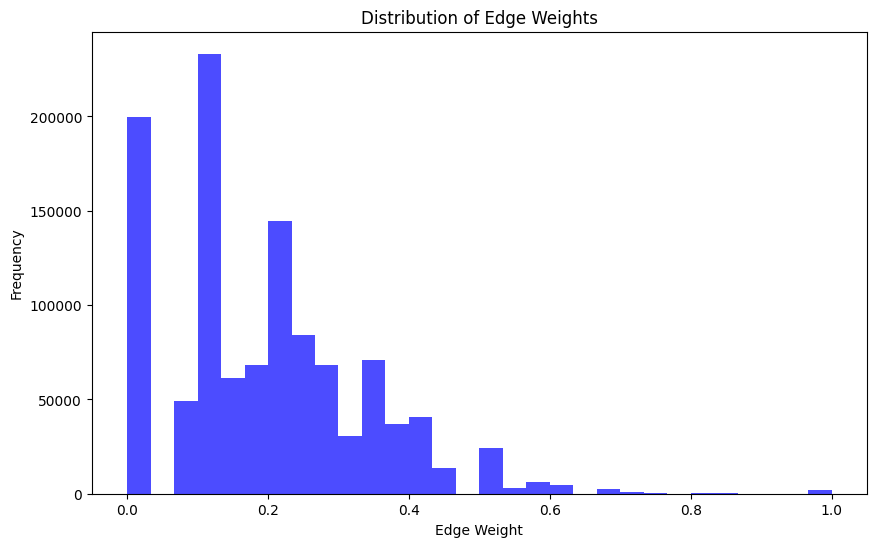

In [ ]:
import matplotlib.pyplot as plt

edge_weights = [data['weight'] for _, _, data in baseline_network.edges(data=True)]

In [ ]:
for idea_text in data_withoutid['solution']:
    idea_words = clean_and_prepare_text(idea_text)

    # Create the semantic subnetwork for the idea
    idea_network = nx.Graph()
    for word in idea_words:
        if word not in idea_network:
            idea_network.add_node(word)
    for word1, word2 in combinations(idea_words, 2):
        if not idea_network.has_edge(word1, word2):
            idea_network.add_edge(word1, word2)

    # Calculate Jaccard Index for each edge in the idea's network
    for node1, node2 in idea_network.edges():
        jaccard_index = calculate_jaccard_index(set(node1), set(node2))
        idea_network[node1][node2]['weight'] = jaccard_index

    # Extract edge weights from the idea's network
    idea_edge_weights = [data['weight'] for _, _, data in idea_network.edges(data=True)]

    if edge_weights and idea_edge_weights:
        # Compare the idea's distribution of edge weights to the prototypical distribution
        ks_stat, p_value = ks_2samp(edge_weights, idea_edge_weights)

        # Output the Kolmogorov-Smirnov statistic as a measure of prototypicality
        print(f"KS Statistic for idea: {ks_stat}")  # A smaller value indicates a more "prototypical" distribution
    else:
        # Handle the case where there are no edge weights (empty network)
        print("Skipping idea due to empty network or baseline.")

KS Statistic for idea: 0.02079611599835446
KS Statistic for idea: 0.05970045685524672
KS Statistic for idea: 0.0256310743226687
KS Statistic for idea: 0.021669717926786514
KS Statistic for idea: 0.03825870288313821
KS Statistic for idea: 0.025732005797457214
KS Statistic for idea: 0.3333082289277716
KS Statistic for idea: 0.04505071377264036
KS Statistic for idea: 0.06518592748275537
KS Statistic for idea: 0.21186457296089006
KS Statistic for idea: 0.06579056271021544
KS Statistic for idea: 0.025733999383338646
KS Statistic for idea: 0.0365345038379285
KS Statistic for idea: 0.11432046776680826
KS Statistic for idea: 0.021551819287184443
KS Statistic for idea: 0.020989990150278498
KS Statistic for idea: 0.0343565727130028
KS Statistic for idea: 0.03253489171998991
KS Statistic for idea: 0.021057153982618537
KS Statistic for idea: 0.04461147879034866
KS Statistic for idea: 0.033704891388165126
KS Statistic for idea: 0.08363079699571241
KS Statistic for idea: 0.0816165923177018
KS Statis

Ideas with semantic subnetworks that have a smaller Kolmogorov–Smirnov statistic have a “more prototypical” edge weight distribution. Con- versely, ideas with semantic subnetworks that have a larger Kolmogorov–Smirnov statistic have a “less prototypical” edge weight distribution.

More prototypical = More promising (combination of novelty and conventionality).